## 0. Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.gridspec as gs


pt.update_plot_defaults()


# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train, shuffle=True, generator=data_generator)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:5000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

epochs = 1
data_seed = 0
network_seed = 42

### Backprop (no weight contraints)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Batch accuracy = 80.83000183105469%


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:943: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:210: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


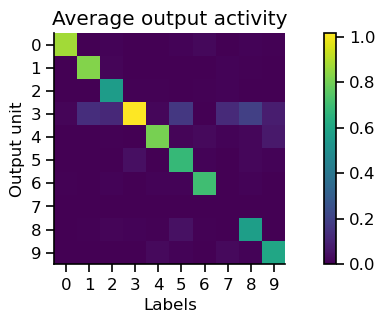

<Figure size 1000x300 with 0 Axes>

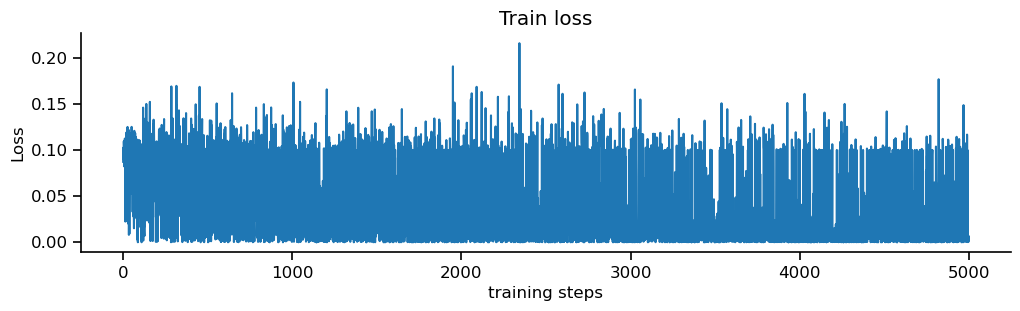

In [2]:
# Create network
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

# Train network
data_generator.manual_seed(data_seed)
bp_network.train_and_validate(train_sub_dataloader, 
                              test_dataloader, 
                              epochs=epochs,
                              val_interval=(0,-1,100),
                              store_history=False, 
                              store_weights=False, 
                              status_bar=True)

pt.plot_batch_accuracy(bp_network, test_dataloader)
plt.figure()
pt.plot_train_loss_history(bp_network)
plt.title('Train loss')
plt.show()

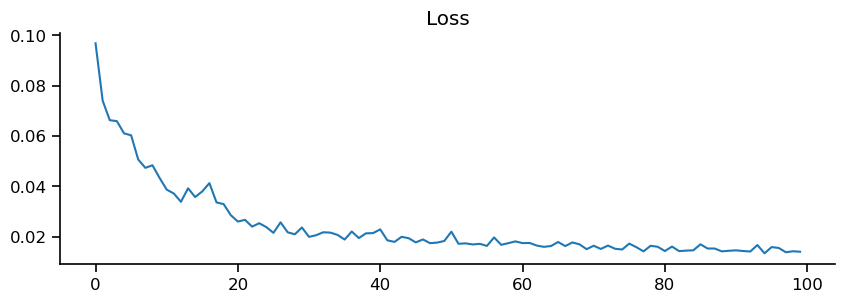

In [3]:
# pt.plot_test_loss_history(bp_network, test_dataloader, stepsize=50)
# pt.plot_MNIST_examples(bp_network, test_dataloader)
plt.figure()
plt.plot(bp_network.val_loss_history)
plt.title('Loss')
plt.show()

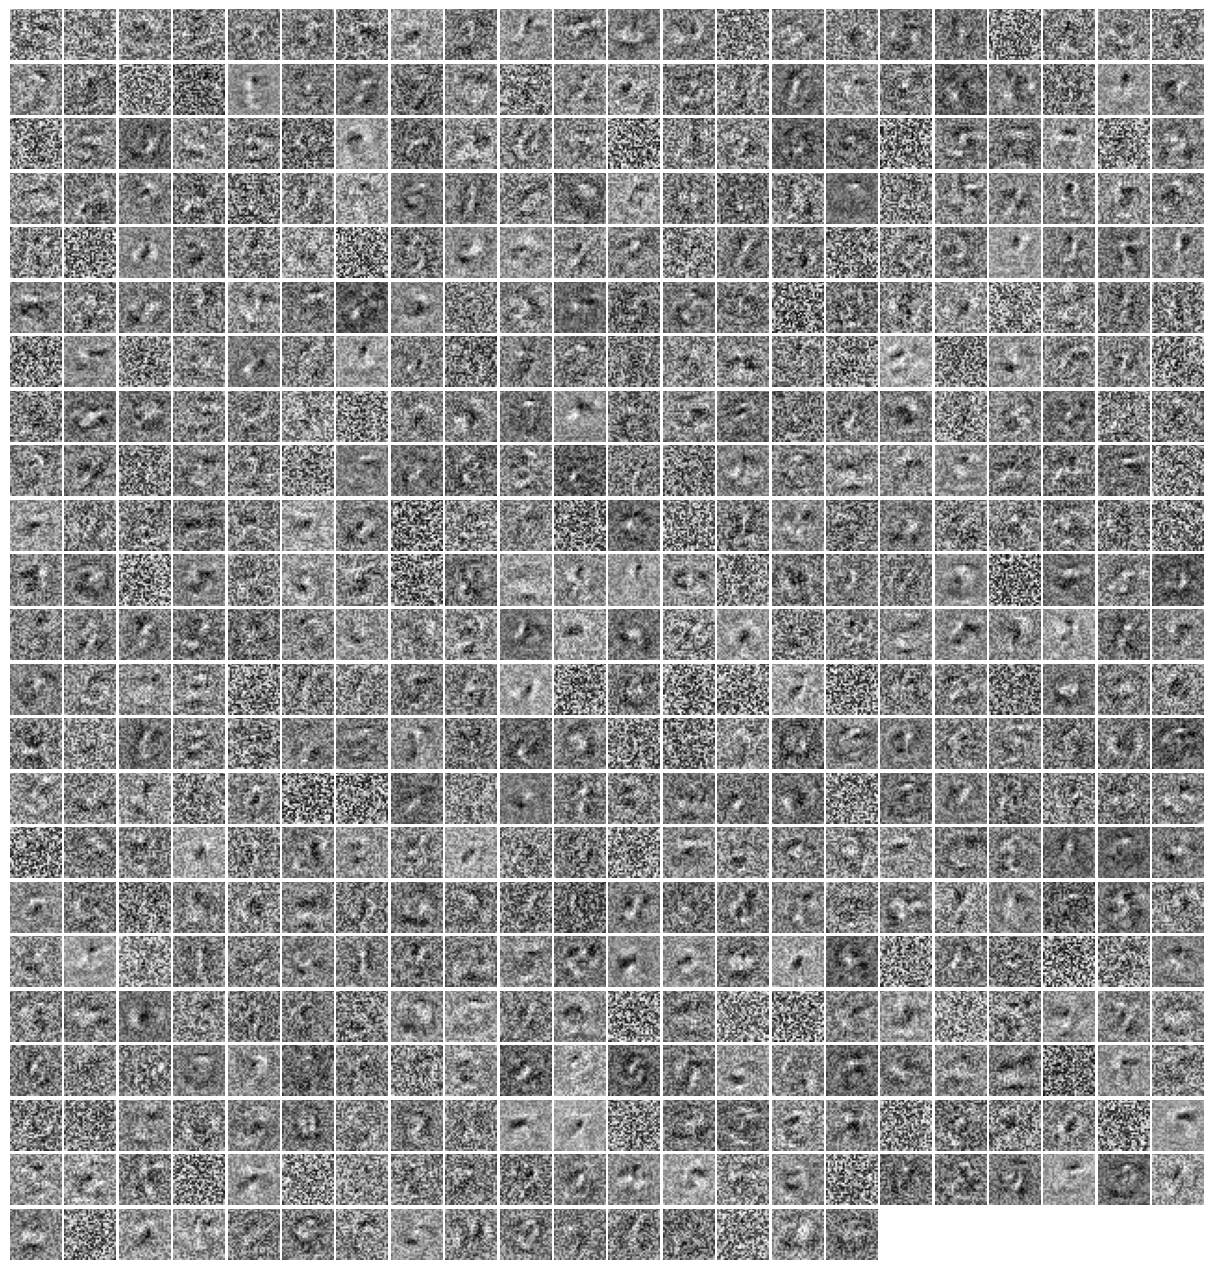

In [4]:
pt.plot_hidden_weights(bp_network.module_dict['H1E_InputE'].weight.detach())

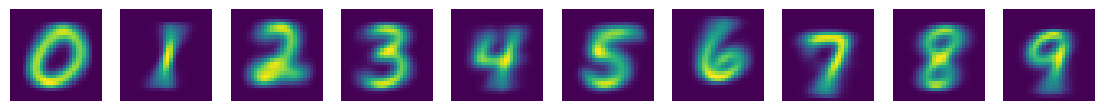

In [6]:
network = bp_network

# Plot activity-weighted average input for each output unit
idx, data, target = next(iter(test_dataloader))
output = network(data).detach()

num_output_units = output.shape[1]

fig, ax = plt.subplots(1,num_output_units,figsize=(14,5))

for i,label in enumerate(range(num_output_units)):
    weighting = output[:,label]
    weighted_average = (data.T@weighting)/weighting.sum()
    img = weighted_average.view(28,28)
    im = ax[i].imshow(img)
    ax[i].axis('off')
    
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

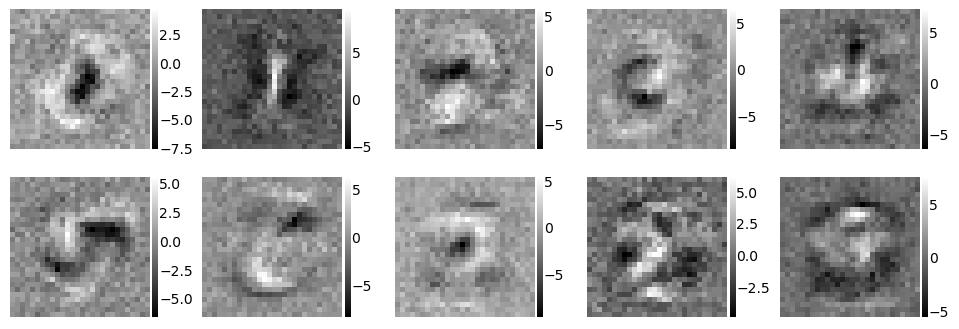

In [199]:
network = bp_network

population = network.Output.E

idx, data, target = next(iter(test_dataloader))
learning_rate = 0.1
num_steps = 10000

num_rows = 2
num_cols = 5
axes = gs.GridSpec(num_rows, num_cols,
                   wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=(12, 4))

for i,unit in enumerate(range(10)):
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    # Find activity-weighted average input for the unit
    idx, data, target = next(iter(test_dataloader))
    network(data)
    pop_activity = population.activity.detach()
    unit_activity = pop_activity[:,unit]
    weighted_avg_input = (data.T@unit_activity)/unit_activity.sum()

    input_image = weighted_avg_input
    
    input_image.requires_grad = True
    optimizer = torch.optim.SGD([input_image], lr=learning_rate)

    for step in tqdm(range(num_steps)):
        im = input_image
        output = network(im)
        pop_activity = population.activity
 
        loss = -torch.log(pop_activity[unit]+0.001) #+ torch.mean(input_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    input_image.requires_grad = False
#     img = (input_image - torch.min(input_image))/(torch.max(input_image)-torch.min(input_image))
    img = input_image
    
    ax = fig.add_subplot(axes[row_idx, col_idx])
    im = ax.imshow(img.view(28,28), cmap='gray')
    cax = fig.add_axes([ax.get_position().x1 + 0.002, ax.get_position().y0, 0.005, ax.get_position().height])
    cbar = plt.colorbar(im, cax=cax)
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(labelsize=10, pad=0.5, length=0) 
    ax.axis('off')

plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

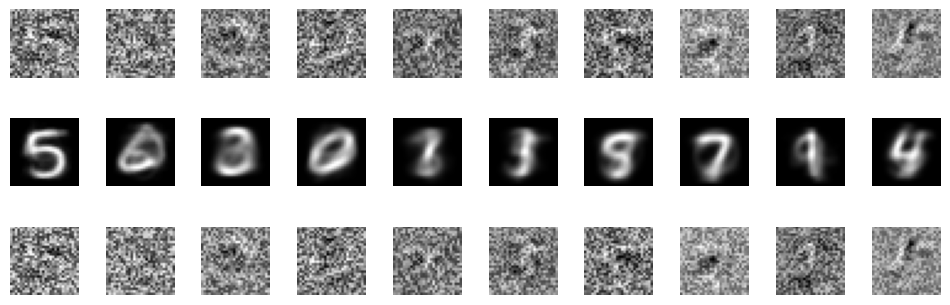

In [12]:
network = bp_network

population = network.H1.E

idx, data, target = next(iter(test_dataloader))
learning_rate = 0.1
num_steps = 10000

num_rows = 3
num_cols = 10
axes = gs.GridSpec(num_rows, num_cols,
                   wspace=0.4, hspace=0.2)
fig = plt.figure(figsize=(12, 4))

# unit_list = [0,7,2,3,6]
# unit_list = [8,9,10,11,12]
unit_list = np.arange(10)

for i,unit in enumerate(unit_list):
    col_idx = i
    
    # Find activity-weighted average input for the unit
    idx, data, target = next(iter(test_dataloader))
    network(data)
    pop_activity = population.activity.detach()
    unit_activity = pop_activity[:,unit]
    weighted_avg_input = (data.T@unit_activity)/unit_activity.sum()

    input_image = weighted_avg_input.clone()
    
    input_image.requires_grad = True
    optimizer = torch.optim.SGD([input_image], lr=learning_rate)

    for step in tqdm(range(num_steps)):
        im = input_image
        output = network(im)
        pop_activity = population.activity
 
        loss = -torch.log(pop_activity[unit]+0.001) #+ torch.mean(input_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    input_image.requires_grad = False
    img = input_image
    
    ax = fig.add_subplot(axes[0, col_idx])
    im = ax.imshow(img.view(28,28), cmap='gray')
#     cax = fig.add_axes([ax.get_position().x1 + 0.002, ax.get_position().y0, 0.005, ax.get_position().height])
#     cbar = plt.colorbar(im, cax=cax)
#     cbar.outline.set_visible(False)
#     cbar.ax.tick_params(labelsize=10, pad=0.5, length=0) 
    if i==10:
        ax.set_title('Max activating image')
    ax.axis('off')
    
    ax = fig.add_subplot(axes[1, col_idx])
    im = ax.imshow(weighted_avg_input.view(28,28), cmap='gray')
#     cax = fig.add_axes([ax.get_position().x1 + 0.002, ax.get_position().y0, 0.005, ax.get_position().height])
#     cbar = plt.colorbar(im, cax=cax)
#     cbar.outline.set_visible(False)
#     cbar.ax.tick_params(labelsize=10, pad=0.5, length=0) 
    if i==10:
        ax.set_title('Activity-weighted average image')
    ax.axis('off')
    

    ax = fig.add_subplot(axes[2, col_idx])
    weights = network.module_dict['H1E_InputE'].weight.detach()[unit]
    im = ax.imshow(weights.view(28,28), cmap='gray')
#     cax = fig.add_axes([ax.get_position().x1 + 0.002, ax.get_position().y0, 0.005, ax.get_position().height])
#     cbar = plt.colorbar(im, cax=cax)
#     cbar.outline.set_visible(False)
#     cbar.ax.tick_params(labelsize=10, pad=0.5, length=0)
    if i==10:
        ax.set_title('Input -> H1 weights')
    ax.axis('off')
    
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

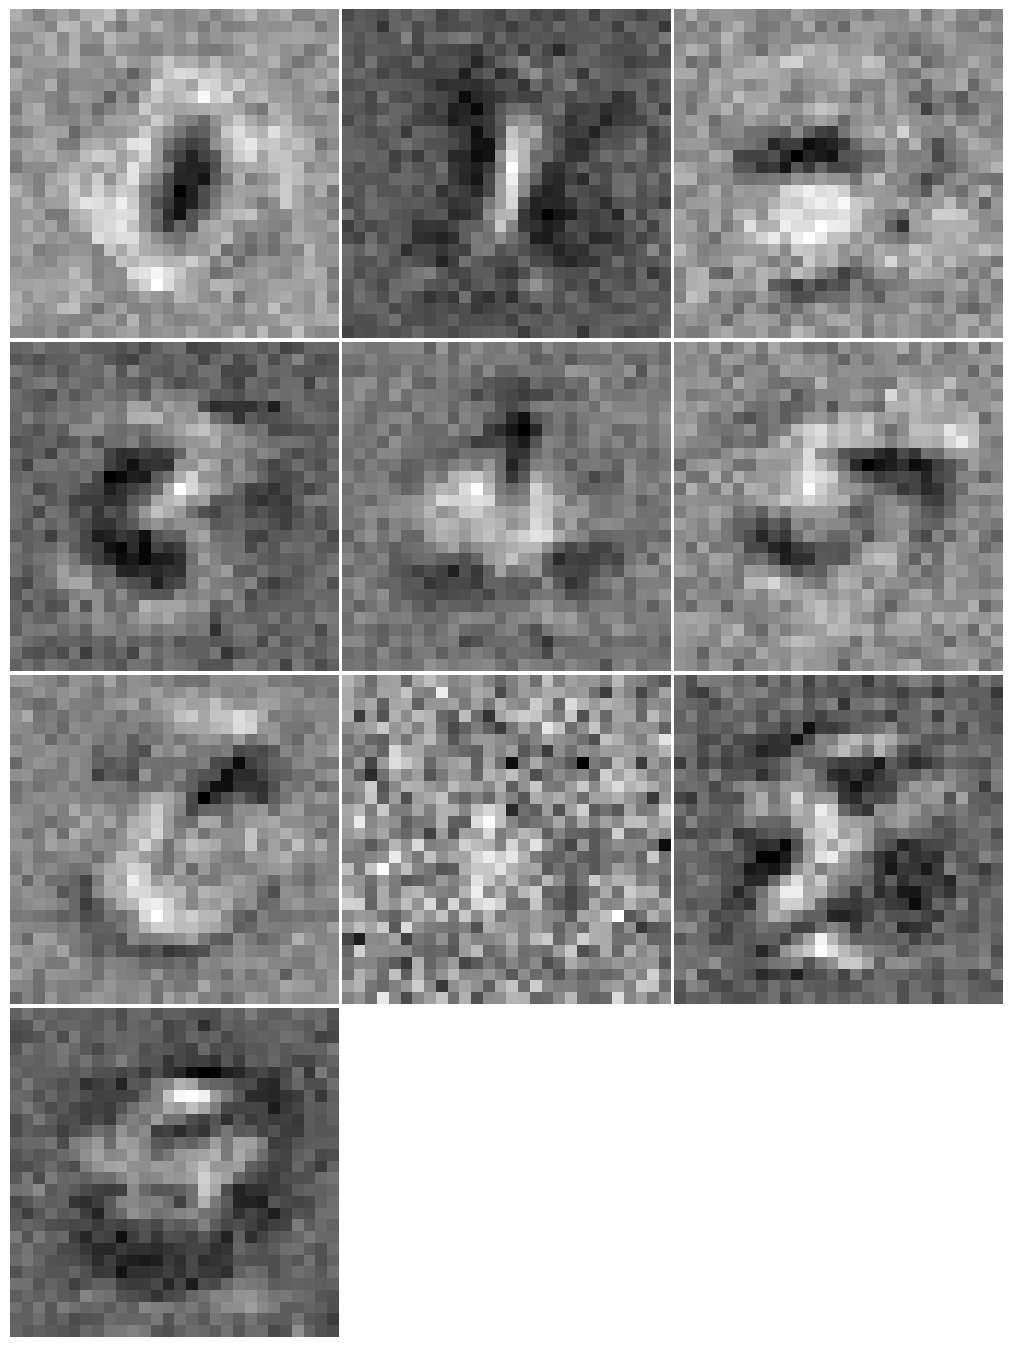

In [4]:
pt.plot_receptive_fields(bp_network.Output.E, test_dataloader)